In [ ]:
## 1. Use permutation instead of combination
## 2. With itself is OK
## 3. Null card if no match



# only generate data for 2 cards per query.
# game rules first iteraion

# a) 3 attributes, 4 values per attribute:

# attributes = {
# 'color': ['red', 'green', 'blue', 'orange'],
# 'fill': ['empty', 'dashed', 'solid', 'checkered'],
# 'shape': ['square', 'circle', 'triangle', 'star'],
# }

# b) Rules:

# A query is formed by a random selection of two cards, these two cards may share the same value for some attributes.
# Query card 1: “red, solid, circle”
# Query card 2: “blue, solid, circle”
# These two cards share two attributes, “solid” and “circle”, which characterize the query.

# A matching key card is one that matches one or more of these shared attributes in the query.
# Key card 1: “green, solid, circle” — matches both query attributes.
# Key card 2: “blue, solid, square” — matches only one of the query attributes.

# If there are no shared attributes among the two cards in the query, the sequence cannot be completed with any key cards. To resolve this, we create a special "null" key card as the matching key card.
# Query card 1: “red, solid, circle”
# Query card 2: “blue, empty, square”
# Key card: "null"
# These two cards share no attributes.

In [5]:
%load_ext autoreload
%autoreload 2

import os
import json

import numpy as np

import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

from collections import Counter

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

from dataraw_sampling import sample_dataset, plot_sampled_distribution, sample_N_datapoints, decode_query_idx, encode_query_idx, queryidx_to_querypair, check_q1q2k_match
from dataraw_full_matrix import gen_card_data, report_gamedata_distribution
from util_distribution import plot_distribution, derive_game_setup_stats, get_distribution
from dataset import GameDatasetFromFullMatrix, GameTestFullDataset, GameDatasetTrainDataset
from datamodule import GameDataModule
from trainmodule import TrainModule

%matplotlib inline
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Generated 65 unqiue cards
Generated 4096 cardpairs
-- 2368 cardpairs with shared concept
-- 1728 cardpairs without shared concept
Number of cardpairs per shared concept [(1, 1728), (0, 1728), (2, 576), (3, 64)]
Total number of matches =  47872
Number of matches per key concept hit =  [(1, 43200), (2, 2880), (0, 1728), (3, 64)]
------------------------
64
[1151.62133694  403.87518426  211.65034456  211.65034456  211.65034456
  211.65034456  211.65034456  211.65034456  211.65034456  211.65034456
  211.65034456   17.28847838   17.28847838   17.28847838   17.28847838
   17.28847838   17.28847838   17.28847838   17.28847838   17.28847838
   17.28847838   17.28847838   17.28847838   17.28847838   17.28847838
   17.28847838   17.28847838   17.28847838   17.28847838   17.28847838
   17.28847838   17.28847838   17.28847838   17.28847838   17.28847838
   17.28847838   17.28847838   17.28847838    1.79450463    1.79450463
    1.79450463    1.79450463    1.79450463    1.79450463    1.79450463
    

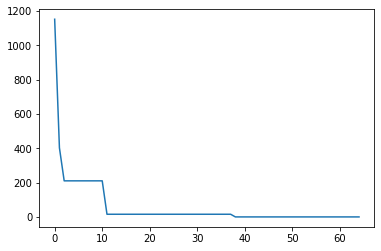

In [3]:
num_attributes = 3
num_attr_vals = 4
game_data = gen_card_data(num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
print('------------------------')
count_table, xy, xyind, xy_div_xyind, distribution = report_gamedata_distribution(game_data, distribution_epsilon=1e-100)

print(np.linalg.matrix_rank(xy_div_xyind[:-1, :]))
u, s, vh = np.linalg.svd(xy_div_xyind[:, :])
print(s)
plt.plot(s)

Generated 28 unqiue cards
Generated 729 cardpairs
-- 513 cardpairs with shared concept
-- 216 cardpairs without shared concept
Number of cardpairs per shared concept [(1, 324), (0, 216), (2, 162), (3, 27)]
Total number of matches =  6075
Number of matches per key concept hit =  [(1, 5184), (2, 648), (0, 216), (3, 27)]
------------------------
27
[413.35139409 122.02908333  60.5912466   60.5912466   60.5912466
  60.5912466   60.5912466   60.5912466    8.44887436   8.44887436
   8.44887436   8.44887436   8.44887436   8.44887436   8.44887436
   8.44887436   8.44887436   8.44887436   8.44887436   8.44887436
   1.47344167   1.47344167   1.47344167   1.47344167   1.47344167
   1.47344167   1.47344167   1.47344167]


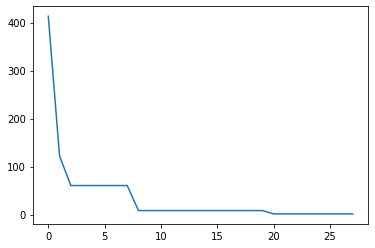

In [4]:
num_attributes = 3
num_attr_vals = 3
game_data = gen_card_data(num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
print('------------------------')
count_table, xy, xyind, xy_div_xyind, distribution = report_gamedata_distribution(game_data, distribution_epsilon=1e-100)

print(np.linalg.matrix_rank(xy_div_xyind[:-1, :]))
u, s, vh = np.linalg.svd(xy_div_xyind[:, :])
print(s)
plt.plot(s)

Generated 9 unqiue cards
Generated 64 cardpairs
-- 56 cardpairs with shared concept
-- 8 cardpairs without shared concept
Number of cardpairs per shared concept [(2, 24), (1, 24), (3, 8), (0, 8)]
Total number of matches =  304
Number of matches per key concept hit =  [(1, 216), (2, 72), (3, 8), (0, 8)]
------------------------
8
[107.48023074  21.73806483   9.15889002   9.15889002   9.15889002
   2.97965898   2.97965898   2.97965898   1.17374517]


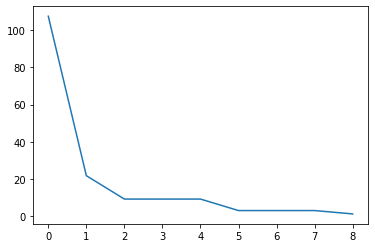

In [2]:
num_attributes = 3
num_attr_vals = 2
game_data = gen_card_data(num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
print('------------------------')
count_table, xy, xyind, xy_div_xyind, distribution = report_gamedata_distribution(game_data, distribution_epsilon=1e-100)

print(np.linalg.matrix_rank(xy_div_xyind[:-1, :]))
u, s, vh = np.linalg.svd(xy_div_xyind[:, :])
print(s)
plt.plot(s)

Generated 126 unqiue cards
Generated 15625 cardpairs
-- 7625 cardpairs with shared concept
-- 8000 cardpairs without shared concept
Number of cardpairs per shared concept [(0, 8000), (1, 6000), (2, 1500), (3, 125)]
Total number of matches =  233125
Number of matches per key concept hit =  [(1, 216000), (2, 9000), (0, 8000), (3, 125)]
------------------------
125
[2.60641674e+03 1.01097416e+03 5.43795675e+02 5.43795675e+02
 5.43795675e+02 5.43795675e+02 5.43795675e+02 5.43795675e+02
 5.43795675e+02 5.43795675e+02 5.43795675e+02 5.43795675e+02
 5.43795675e+02 5.43795675e+02 2.99910762e+01 2.99910762e+01
 2.99910762e+01 2.99910762e+01 2.99910762e+01 2.99910762e+01
 2.99910762e+01 2.99910762e+01 2.99910762e+01 2.99910762e+01
 2.99910762e+01 2.99910762e+01 2.99910762e+01 2.99910762e+01
 2.99910762e+01 2.99910762e+01 2.99910762e+01 2.99910762e+01
 2.99910762e+01 2.99910762e+01 2.99910762e+01 2.99910762e+01
 2.99910762e+01 2.99910762e+01 2.99910762e+01 2.99910762e+01
 2.99910762e+01 2.9991076

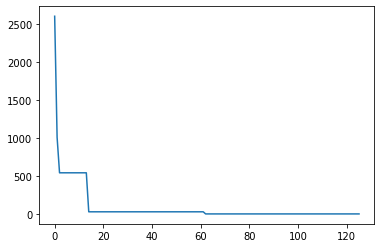

In [4]:
num_attributes = 3
num_attr_vals = 5
game_data = gen_card_data(num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
print('------------------------')
count_table, xy, xyind, xy_div_xyind, distribution = report_gamedata_distribution(game_data, distribution_epsilon=1e-100)

print(np.linalg.matrix_rank(xy_div_xyind[:-1, :]))
u, s, vh = np.linalg.svd(xy_div_xyind[:, :])
print(s)
plt.plot(s)

Generated 217 unqiue cards
Generated 46656 cardpairs
-- 19656 cardpairs with shared concept
-- 27000 cardpairs without shared concept
Number of cardpairs per shared concept [(0, 27000), (1, 16200), (2, 3240), (3, 216)]
Total number of matches =  843696
Number of matches per key concept hit =  [(1, 793800), (0, 27000), (2, 22680), (3, 216)]
------------------------
216
[5.13457034e+03 2.12862917e+03 1.16251068e+03 1.16251068e+03
 1.16251068e+03 1.16251068e+03 1.16251068e+03 1.16251068e+03
 1.16251068e+03 1.16251068e+03 1.16251068e+03 1.16251068e+03
 1.16251068e+03 1.16251068e+03 1.16251068e+03 1.16251068e+03
 1.16251068e+03 4.69876139e+01 4.69876139e+01 4.69876139e+01
 4.69876139e+01 4.69876139e+01 4.69876139e+01 4.69876139e+01
 4.69876139e+01 4.69876139e+01 4.69876139e+01 4.69876139e+01
 4.69876139e+01 4.69876139e+01 4.69876139e+01 4.69876139e+01
 4.69876139e+01 4.69876139e+01 4.69876139e+01 4.69876139e+01
 4.69876139e+01 4.69876139e+01 4.69876139e+01 4.69876139e+01
 4.69876139e+01 4.6

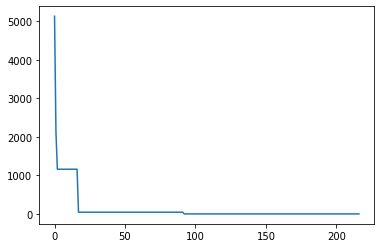

In [5]:
num_attributes = 3
num_attr_vals = 6
game_data = gen_card_data(num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
print('------------------------')
count_table, xy, xyind, xy_div_xyind, distribution = report_gamedata_distribution(game_data, distribution_epsilon=1e-100)

print(np.linalg.matrix_rank(xy_div_xyind[:-1, :]))
u, s, vh = np.linalg.svd(xy_div_xyind[:, :])
print(s)
plt.plot(s)

In [ ]:
num_attributes = 3
num_attr_vals = 7
game_data = gen_card_data(num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
print('------------------------')
count_table, xy, xyind, xy_div_xyind, distribution = report_gamedata_distribution(game_data, distribution_epsilon=1e-100)

print(np.linalg.matrix_rank(xy_div_xyind[:-1, :]))
u, s, vh = np.linalg.svd(xy_div_xyind[:, :])
print(s)
plt.plot(s)

Generated 344 unqiue cards
Generated 117649 cardpairs
-- 43561 cardpairs with shared concept
-- 74088 cardpairs without shared concept
Number of cardpairs per shared concept [(0, 74088), (1, 37044), (2, 6174), (3, 343)]
Total number of matches =  2494639
Number of matches per key concept hit =  [(1, 2370816), (0, 74088), (2, 49392), (3, 343)]
------------------------
343


Generated 5 unqiue cards
Generated 16 cardpairs
-- 12 cardpairs with shared concept
-- 4 cardpairs without shared concept
Number of cardpairs per shared concept [(1, 8), (2, 4), (0, 4)]
Total number of matches =  32
Number of matches per key concept hit =  [(1, 24), (2, 4), (0, 4)]
------------------------
4
[16.          7.91794655  4.81870882  4.81870882  1.52380952]


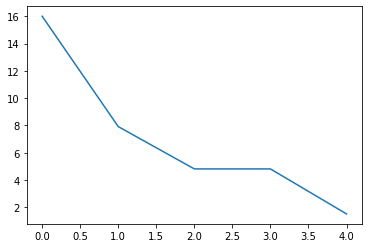

In [5]:
num_attributes = 2
num_attr_vals = 2
game_data = gen_card_data(num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
print('------------------------')
count_table, xy, xyind, xy_div_xyind, distribution = report_gamedata_distribution(game_data, distribution_epsilon=1e-100)

print(np.linalg.matrix_rank(xy_div_xyind[:-1, :]))
u, s, vh = np.linalg.svd(xy_div_xyind[:, :])
print(s)
plt.plot(s)

Generated 10 unqiue cards
Generated 81 cardpairs
-- 45 cardpairs with shared concept
-- 36 cardpairs without shared concept
Number of cardpairs per shared concept [(1, 36), (0, 36), (2, 9)]
Total number of matches =  189
Number of matches per key concept hit =  [(1, 144), (0, 36), (2, 9)]
------------------------
9
[31.5        24.85981457 16.33953746 16.33953746 16.33953746 16.33953746
  2.22352941  2.22352941  2.22352941  2.22352941]


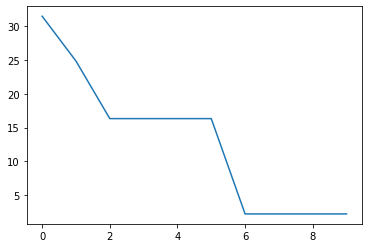

In [6]:
num_attributes = 2
num_attr_vals = 3
game_data = gen_card_data(num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
print('------------------------')
count_table, xy, xyind, xy_div_xyind, distribution = report_gamedata_distribution(game_data, distribution_epsilon=1e-100)

print(np.linalg.matrix_rank(xy_div_xyind[:-1, :]))
u, s, vh = np.linalg.svd(xy_div_xyind[:, :])
print(s)
plt.plot(s)

Generated 17 unqiue cards
Generated 256 cardpairs
-- 112 cardpairs with shared concept
-- 144 cardpairs without shared concept
Number of cardpairs per shared concept [(0, 144), (1, 96), (2, 16)]
Total number of matches =  640
Number of matches per key concept hit =  [(1, 480), (0, 144), (2, 16)]
------------------------
16
[54.62196255 53.33333333 36.83685455 36.83685455 36.83685455 36.83685455
 36.83685455 36.83685455  2.94930876  2.94930876  2.94930876  2.94930876
  2.94930876  2.94930876  2.94930876  2.94930876  2.94930876]


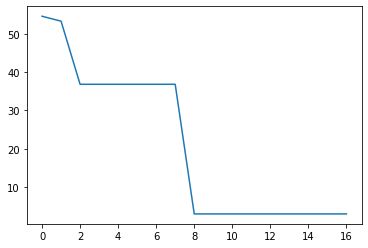

In [7]:
num_attributes = 2
num_attr_vals = 4
game_data = gen_card_data(num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
print('------------------------')
count_table, xy, xyind, xy_div_xyind, distribution = report_gamedata_distribution(game_data, distribution_epsilon=1e-100)

print(np.linalg.matrix_rank(xy_div_xyind[:-1, :]))
u, s, vh = np.linalg.svd(xy_div_xyind[:, :])
print(s)
plt.plot(s)

Generated 50 unqiue cards
Generated 2401 cardpairs
-- 637 cardpairs with shared concept
-- 1764 cardpairs without shared concept
Number of cardpairs per shared concept [(0, 1764), (1, 588), (2, 49)]
Total number of matches =  6517
Number of matches per key concept hit =  [(1, 4704), (0, 1764), (2, 49)]
------------------------
49
[242.24100683 167.46624557 167.46624557 167.46624557 167.46624557
 167.46624557 167.46624557 167.46624557 167.46624557 167.46624557
 167.46624557 167.46624557 167.46624557 155.16666667   5.16812054
   5.16812054   5.16812054   5.16812054   5.16812054   5.16812054
   5.16812054   5.16812054   5.16812054   5.16812054   5.16812054
   5.16812054   5.16812054   5.16812054   5.16812054   5.16812054
   5.16812054   5.16812054   5.16812054   5.16812054   5.16812054
   5.16812054   5.16812054   5.16812054   5.16812054   5.16812054
   5.16812054   5.16812054   5.16812054   5.16812054   5.16812054
   5.16812054   5.16812054   5.16812054   5.16812054   5.16812054]


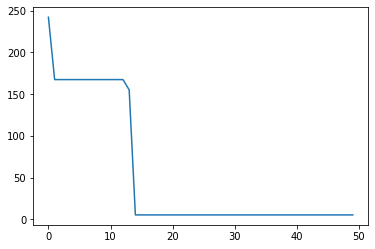

In [10]:
num_attributes = 2
num_attr_vals = 7
game_data = gen_card_data(num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
print('------------------------')
count_table, xy, xyind, xy_div_xyind, distribution = report_gamedata_distribution(game_data, distribution_epsilon=1e-100)

print(np.linalg.matrix_rank(xy_div_xyind[:-1, :]))
u, s, vh = np.linalg.svd(xy_div_xyind[:, :])
print(s)
plt.plot(s)

Generated 65 unqiue cards
Generated 4096 cardpairs
-- 960 cardpairs with shared concept
-- 3136 cardpairs without shared concept
Number of cardpairs per shared concept [(0, 3136), (1, 896), (2, 64)]
Total number of matches =  11264
Number of matches per key concept hit =  [(1, 8064), (0, 3136), (2, 64)]
------------------------
64
[343.50617647 238.28169142 238.28169142 238.28169142 238.28169142
 238.28169142 238.28169142 238.28169142 238.28169142 238.28169142
 238.28169142 238.28169142 238.28169142 238.28169142 238.28169142
 201.14285714   5.91286089   5.91286089   5.91286089   5.91286089
   5.91286089   5.91286089   5.91286089   5.91286089   5.91286089
   5.91286089   5.91286089   5.91286089   5.91286089   5.91286089
   5.91286089   5.91286089   5.91286089   5.91286089   5.91286089
   5.91286089   5.91286089   5.91286089   5.91286089   5.91286089
   5.91286089   5.91286089   5.91286089   5.91286089   5.91286089
   5.91286089   5.91286089   5.91286089   5.91286089   5.91286089
   5.91

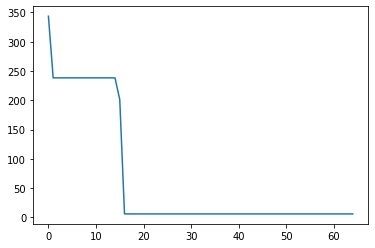

In [11]:
num_attributes = 2
num_attr_vals = 8
game_data = gen_card_data(num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
print('------------------------')
count_table, xy, xyind, xy_div_xyind, distribution = report_gamedata_distribution(game_data, distribution_epsilon=1e-100)

print(np.linalg.matrix_rank(xy_div_xyind[:-1, :]))
u, s, vh = np.linalg.svd(xy_div_xyind[:, :])
print(s)
plt.plot(s)

Generated 26 unqiue cards
Generated 625 cardpairs
-- 225 cardpairs with shared concept
-- 400 cardpairs without shared concept
Number of cardpairs per shared concept [(0, 400), (1, 200), (2, 25)]
Total number of matches =  1625
Number of matches per key concept hit =  [(1, 1200), (0, 400), (2, 25)]
------------------------
25
[99.48979592 81.25       67.94448863 67.94448863 67.94448863 67.94448863
 67.94448863 67.94448863 67.94448863 67.94448863  3.68480726  3.68480726
  3.68480726  3.68480726  3.68480726  3.68480726  3.68480726  3.68480726
  3.68480726  3.68480726  3.68480726  3.68480726  3.68480726  3.68480726
  3.68480726  3.68480726]


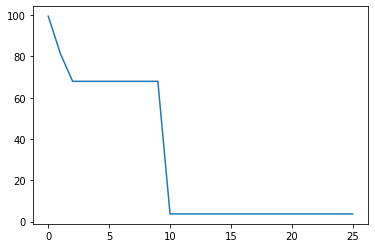

In [3]:
num_attributes = 2
num_attr_vals = 5
game_data = gen_card_data(num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
print('------------------------')
count_table, xy, xyind, xy_div_xyind, distribution = report_gamedata_distribution(game_data, distribution_epsilon=1e-100)

print(np.linalg.matrix_rank(xy_div_xyind[:-1, :]))
u, s, vh = np.linalg.svd(xy_div_xyind[:, :])
print(s)
plt.plot(s)

Generated 37 unqiue cards
Generated 1296 cardpairs
-- 396 cardpairs with shared concept
-- 900 cardpairs without shared concept
Number of cardpairs per shared concept [(0, 900), (1, 360), (2, 36)]
Total number of matches =  3456
Number of matches per key concept hit =  [(1, 2520), (0, 900), (2, 36)]
------------------------
36
[161.44021515 115.2        111.06902887 111.06902887 111.06902887
 111.06902887 111.06902887 111.06902887 111.06902887 111.06902887
 111.06902887 111.06902887   4.42509603   4.42509603   4.42509603
   4.42509603   4.42509603   4.42509603   4.42509603   4.42509603
   4.42509603   4.42509603   4.42509603   4.42509603   4.42509603
   4.42509603   4.42509603   4.42509603   4.42509603   4.42509603
   4.42509603   4.42509603   4.42509603   4.42509603   4.42509603
   4.42509603   4.42509603]


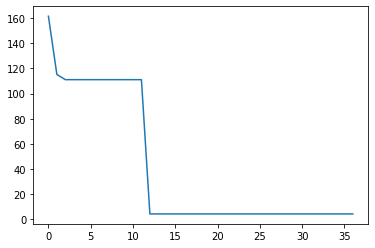

In [4]:
num_attributes = 2
num_attr_vals = 6
game_data = gen_card_data(num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
print('------------------------')
count_table, xy, xyind, xy_div_xyind, distribution = report_gamedata_distribution(game_data, distribution_epsilon=1e-100)

print(np.linalg.matrix_rank(xy_div_xyind[:-1, :]))
u, s, vh = np.linalg.svd(xy_div_xyind[:, :])
print(s)
plt.plot(s)

Generated 82 unqiue cards
Generated 6561 cardpairs
-- 5265 cardpairs with shared concept
-- 1296 cardpairs without shared concept
Number of cardpairs per shared concept [(1, 2592), (2, 1944), (0, 1296), (3, 648), (4, 81)]
Total number of matches =  200961
Number of matches per key concept hit =  [(1, 165888), (2, 31104), (3, 2592), (0, 1296), (4, 81)]
------------------------
81
[5.58225000e+03 6.57281695e+02 2.60386131e+02 2.60386131e+02
 2.60386131e+02 2.60386131e+02 2.60386131e+02 2.60386131e+02
 2.60386131e+02 2.60386131e+02 3.71911470e+01 3.71911470e+01
 3.71911470e+01 3.71911470e+01 3.71911470e+01 3.71911470e+01
 3.71911470e+01 3.71911470e+01 3.71911470e+01 3.71911470e+01
 3.71911470e+01 3.71911470e+01 3.71911470e+01 3.71911470e+01
 3.71911470e+01 3.71911470e+01 3.71911470e+01 3.71911470e+01
 3.71911470e+01 3.71911470e+01 3.71911470e+01 3.71911470e+01
 3.71911470e+01 3.71911470e+01 6.56619619e+00 6.56619619e+00
 6.56619619e+00 6.56619619e+00 6.56619619e+00 6.56619619e+00
 6.56619

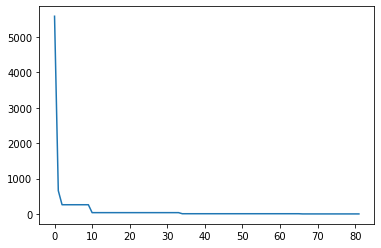

In [6]:
num_attributes = 4
num_attr_vals = 3
game_data = gen_card_data(num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
print('------------------------')
count_table, xy, xyind, xy_div_xyind, distribution = report_gamedata_distribution(game_data, distribution_epsilon=1e-100)

print(np.linalg.matrix_rank(xy_div_xyind[:-1, :]))
u, s, vh = np.linalg.svd(xy_div_xyind[:, :])
print(s)
plt.plot(s)

Generated 17 unqiue cards
Generated 256 cardpairs
-- 240 cardpairs with shared concept
-- 16 cardpairs without shared concept
Number of cardpairs per shared concept [(2, 96), (3, 64), (1, 64), (4, 16), (0, 16)]
Total number of matches =  2816
Number of matches per key concept hit =  [(1, 1728), (2, 864), (3, 192), (4, 16), (0, 16)]
------------------------
16
[704.          62.32183487  19.03284939  19.03284939  19.03284939
  19.03284939   6.36317597   6.36317597   6.36317597   6.36317597
   6.36317597   6.36317597   2.53676703   2.53676703   2.53676703
   2.53676703   1.0727619 ]


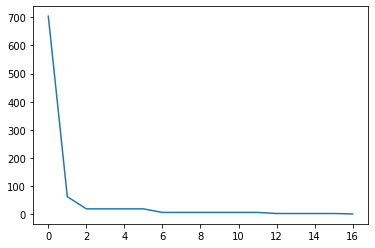

In [7]:
num_attributes = 4
num_attr_vals = 2
game_data = gen_card_data(num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
print('------------------------')
count_table, xy, xyind, xy_div_xyind, distribution = report_gamedata_distribution(game_data, distribution_epsilon=1e-100)

print(np.linalg.matrix_rank(xy_div_xyind[:-1, :]))
u, s, vh = np.linalg.svd(xy_div_xyind[:, :])
print(s)
plt.plot(s)

In [9]:
3**5

243

In [ ]:
Total size 538002
Sparsity 0.012195121951219513

In [10]:
538002 * 0.012195121951219513

6561.0

In [11]:
1/82

0.012195121951219513

In [12]:
1/243

0.00411522633744856

In [13]:
243 * 243

59049